***Week1-6***



***We import useful librairies***

In [1]:
pip install datacleaner

  Created wheel for datacleaner: filename=datacleaner-0.1.5-cp36-none-any.whl size=7412 sha256=f2f528fc1decc61592abb603b248792887d73b4c038594dc2d782a76523bb29d
  Stored in directory: /root/.cache/pip/wheels/47/e3/74/4e055e42b3d4a5deab827f4d950e8e71d506c6e79231ad4576
Successfully built datacleaner


In [0]:
import pandas as pd
import numpy as np
from google.colab import drive
import seaborn as sn
import matplotlib.pyplot as plt
from datacleaner import autoclean
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import time
import os

In [123]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
os.chdir("/content/drive/My Drive")

***Data loading***

In [0]:
transaction_train = pd.read_csv('train_transaction.csv')
identity_train = pd.read_csv('train_identity.csv')
transaction_test = pd.read_csv('test_transaction.csv')
identity_test = pd.read_csv('test_identity.csv')

***A) Data preprocessing***

***Merging dataset***

In [0]:
X_train = pd.merge(identity_train, transaction_train, on= 'TransactionID')

In [127]:
X_train.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,...,1.0,1.0,1.0,1.0,1.0,1.0,166.215393,166.215393,166.215393,90.327904,90.327904,31.841299,90.327904,90.327904,90.327904,90.327904,0.0,0.0,0.0,75.887497,75.887497,75.887497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
X_test = pd.merge(identity_test, transaction_test, on= 'TransactionID')

In [129]:
X_test.head()

,TransactionID,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,...,NaN,NaN,1.0,1.0,1.0,1.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,...,0.0,0.0,1.0,3.0,2.0,1.0,0.000,270.000,90.000,0.0,270.0,0.0,90.0,60.0,310.0,130.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,8.0,2.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,310.0,90.0,0.0,310.0,90.0,0.0,0.0,0.0
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,...,NaN,NaN,1.0,1.0,1.0,1.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,...,NaN,NaN,1.0,1.0,1.0,1.0,6.271,6.271,6.271,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,6.271,6.271,6.271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,...,NaN,NaN,1.0,1.0,1.0,1.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
X_train.shape, X_test.shape

((144233, 434), (141907, 433))

***Target: isFraud***

In [131]:
y_train = X_train.isFraud
X_train = X_train.drop(['isFraud', 'TransactionID'],axis= 1)
transactionIDTest = X_test['TransactionID']
X_test = X_test.drop('TransactionID', axis= 1)
X_train.shape, X_test.shape

((144233, 432), (141907, 432))

***Data cleaning***

In [132]:
X_train.isnull().sum()

id_01        0
id_02     3361
id_03    77909
id_04    77909
id_05     7368
         ...  
V335     62192
V336     62192
V337     62192
V338     62192
V339     62192
Length: 432, dtype: int64

***First time : We decide to drop features with 70% of Nan values.***


In [0]:
droppedColumns = []
for i in X_train.columns:
  nanSum = X_train[i].isnull().sum()
  proportion = nanSum/X_train.shape[0]
  if proportion > 0.70:
    X_train = X_train.drop(i, axis= 1)  
    droppedColumns.append(i)    

In [134]:
X_train.shape 

(144233, 397)

***Features dropped in X_train***

In [135]:
droppedColumns

['id_07',
 'id_08',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27',
 'dist1',
 'dist2',
 'D2',
 'D3',
 'D5',
 'D7',
 'D11',
 'M1',
 'M2',
 'M3',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11']

***We don't know what each column describes exactly. After looking on kaggle website discussion, we found the following information.***

***TransactionDT: timedelta from a given reference datetime (not an actual timestamp)*** 

***TransactionAMT : That is transaction amount in USD**

***ProductCD: Product code for each transaction***

***card1 - card6: Information about payment card*** 

***addr: Address for purchaser and recipient***

***addr1 as billing region***

***addr2 as billing country***

***dist: distance ***
***"distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc***


***P_ and (R_) emaildomain: Purchaser and recipient email domain ***

***C1-C14: Counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked. ***

***D1-D15: Timedelta, such as days between previous transaction, etc. ***

***M1-M9: Match, such as names on card and address, etc.***

***Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.***

***id01-id11 : Numerical features for identity***

***IsFraud =1 means fradulent transaction, otherwise nofradulent transaction.***


***Distribution of target (fradulent and nonfradulent transaction)***

In [136]:
y_train.value_counts(normalize= True)

0    0.92153
1    0.07847
Name: isFraud, dtype: float64

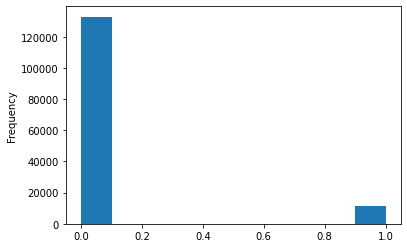

In [137]:
y_train.plot.hist()

***We have approximatively 92% of non fradulent transaction and 8% of fradulent transaction.***

***Let's replace missing values in each features. We will use datacleaner library for dealing with numerical features. The method autoclean from datacleaner library replaces Nan in numerical features by its median.***

***Its documentation can be find there 
https://github.com/rhiever/datacleaner***

***We create a mask for selecting categorical features.***

In [138]:
mask1 = X_train.dtypes==object
categoricalColumns = X_train.columns[mask1]
categoricalFeatures = X_train[categoricalColumns]
categoricalFeatures.head()

,id_12,id_15,id_16,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M4
0,NotFound,New,NotFound,New,NotFound,Android 7.0,samsung browser 6.2,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,H,mastercard,credit,gmail.com,NaN,NaN
1,NotFound,New,NotFound,New,NotFound,iOS 11.1.2,mobile safari 11.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,H,visa,debit,anonymous.com,NaN,NaN
2,NotFound,Found,Found,Found,Found,NaN,chrome 62.0,NaN,NaN,F,F,T,T,desktop,Windows,C,mastercard,credit,gmail.com,gmail.com,M0
3,NotFound,New,NotFound,New,NotFound,NaN,chrome 62.0,NaN,NaN,F,F,T,T,desktop,NaN,C,mastercard,debit,hotmail.com,hotmail.com,M0
4,NotFound,Found,Found,Found,Found,Mac OS X 10_11_6,chrome 62.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS,H,visa,debit,aol.com,NaN,NaN


***Mask for selecting numerical features***

In [139]:
mask2 = X_train.dtypes!=object
numericalColumns = X_train.columns[mask2]
numericalFeatures = X_train[numericalColumns]
numericalFeatures.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_32,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,-480.0,166.0,NaN,542.0,144.0,32.0,86506,50.000,4497,514.0,150.0,102.0,420.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,100.0,49.0,-300.0,166.0,NaN,621.0,500.0,32.0,86535,15.000,2803,100.0,150.0,226.0,337.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-5.0,191631.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,52.0,NaN,121.0,NaN,410.0,142.0,NaN,86549,75.887,16496,352.0,117.0,134.0,NaN,NaN,1.0,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,166.215393,166.215393,166.215393,90.327904,90.327904,31.841299,90.327904,90.327904,90.327904,90.327904,0.0,0.0,0.0,75.887497,75.887497,75.887497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,100.0,52.0,NaN,225.0,NaN,176.0,507.0,NaN,86555,16.495,4461,375.0,185.0,224.0,NaN,NaN,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,7460.0,0.0,0.0,1.0,0.0,0.0,0.0,100.0,NaN,-300.0,166.0,15.0,529.0,575.0,24.0,86620,30.000,1790,555.0,150.0,226.0,170.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***Removing Nan in numerical features in training dataset***

In [140]:
numericalFeatures = autoclean(numericalFeatures)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [141]:
numericalFeatures.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_32,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,0.0,70787.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,52.0,-480.0,166.0,15.0,542.0,144.0,32.0,86506,50.000,4497,514.0,150.0,102.0,420.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-5.0,98945.0,0.0,0.0,0.0,-5.0,0.0,0.0,100.0,49.0,-300.0,166.0,15.0,621.0,500.0,32.0,86535,15.000,2803,100.0,150.0,226.0,337.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-5.0,191631.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,52.0,-300.0,121.0,15.0,410.0,142.0,24.0,86549,75.887,16496,352.0,117.0,134.0,299.0,87.0,1.0,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,166.215393,166.215393,166.215393,90.327904,90.327904,31.841299,90.327904,90.327904,90.327904,90.327904,0.0,0.0,0.0,75.887497,75.887497,75.887497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-5.0,221832.0,0.0,0.0,0.0,-6.0,0.0,0.0,100.0,52.0,-300.0,225.0,15.0,176.0,507.0,24.0,86555,16.495,4461,375.0,185.0,224.0,299.0,87.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,7460.0,0.0,0.0,1.0,0.0,0.0,0.0,100.0,52.0,-300.0,166.0,15.0,529.0,575.0,24.0,86620,30.000,1790,555.0,150.0,226.0,170.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [142]:
numericalFeatures.isnull().sum()

id_01    0
id_02    0
id_03    0
id_04    0
id_05    0
        ..
V335     0
V336     0
V337     0
V338     0
V339     0
Length: 376, dtype: int64

***Verification of zero-Nan in each feature***

In [143]:
nonNull = numericalFeatures.isnull().sum() != 0
columnNonNull = numericalFeatures.columns[nonNull]
columnNonNull

Index([], dtype='object')

***Correlation between some numerical features .***

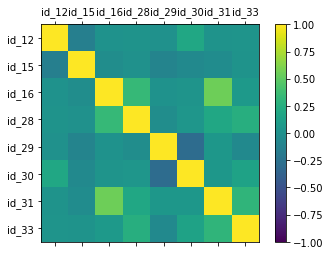

,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10
id_01,1.000000,-0.138796,0.018068,0.023900,0.013526,0.192059,0.024796,0.033367
id_02,-0.138796,1.000000,-0.022330,0.007991,-0.096635,-0.050298,-0.024059,0.023517
id_03,0.018068,-0.022330,1.000000,0.336048,0.022965,0.038186,0.555988,0.083404
id_04,0.023900,0.007991,0.336048,1.000000,-0.019669,0.053289,0.193375,0.257307
id_05,0.013526,-0.096635,0.022965,-0.019669,1.000000,-0.296007,0.060512,-0.047380
id_06,0.192059,-0.050298,0.038186,0.053289,-0.296007,1.000000,0.055425,0.149544
id_09,0.024796,-0.024059,0.555988,0.193375,0.060512,0.055425,1.000000,0.309707
id_10,0.033367,0.023517,0.083404,0.257307,-0.047380,0.149544,0.309707,1.000000


In [144]:
correlations = numericalFeatures[['id_01','id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10']].corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
names = ['']+list(categoricalFeatures)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()
correlations

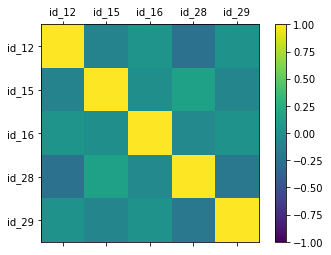

,TransactionAmt,TransactionDT,card2,card3,card5
TransactionAmt,1.000000,-0.101800,0.036785,-0.256387,0.016490
TransactionDT,-0.101800,1.000000,-0.003114,0.148160,-0.090505
card2,0.036785,-0.003114,1.000000,-0.058810,0.027964
card3,-0.256387,0.148160,-0.058810,1.000000,-0.201817
card5,0.016490,-0.090505,0.027964,-0.201817,1.000000


In [145]:
correlations = numericalFeatures[['TransactionAmt','TransactionDT','card2','card3','card5']].corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
names = ['']+list(categoricalFeatures)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()
correlations

***Conclusion: We can not deduce a correlation between these features.***

***Standardization of numerical features***

In [0]:
numericalFeatures = (numericalFeatures-numericalFeatures.mean())/numericalFeatures.std()


In [147]:
numericalFeatures.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_32,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,0.708847,-0.650761,-0.068041,0.056904,-0.299053,0.394033,-0.066546,0.077589,0.223164,0.312880,-2.121011,-0.751408,0.253218,1.364828,-1.747853,2.207269,-1.264728,-0.336049,-1.066243,0.766873,-0.602057,-1.999409,1.615026,0.107814,-0.107284,-0.114465,-0.075809,-0.118258,NaN,-0.110049,-0.089825,-0.101609,NaN,-0.103364,-0.109512,-0.090208,-0.117819,-0.108959,-0.307669,-0.281598,...,-0.195786,-0.19784,-0.066934,-0.198085,-0.145638,NaN,-0.088126,-0.094226,-0.097090,-0.038626,-0.109518,-0.024710,-0.086095,-0.184059,-0.181806,-0.183967,-0.082207,-0.08823,-0.09109,-0.049377,-0.092519,-0.077843,-0.083629,-0.092403,-0.093894,-0.143876,-0.16091,-0.162367,-0.159237,-0.112485,-0.123162,-0.087418,-0.092719,-0.095984,-0.030358,-0.114516,-0.07822,-0.062366,-0.103788,-0.092958
1,0.360365,-0.472493,-0.068041,0.056904,-0.299053,0.084089,-0.066546,0.077589,0.223164,0.043474,0.337338,-0.751408,0.253218,1.934452,0.625002,2.207269,-1.264722,-0.686573,-1.401845,-1.823361,-0.602057,0.774319,0.518542,0.107814,-0.107284,-0.114465,-0.075809,-0.118258,NaN,-0.110049,-0.089825,-0.101609,NaN,-0.103364,-0.109512,-0.090208,-0.117819,-0.108959,-0.307669,-0.281598,...,-0.195786,-0.19784,-0.066934,-0.198085,-0.145638,NaN,-0.088126,-0.094226,-0.097090,-0.038626,-0.109518,-0.024710,-0.086095,-0.184059,-0.181806,-0.183967,-0.082207,-0.08823,-0.09109,-0.049377,-0.092519,-0.077843,-0.083629,-0.092403,-0.093894,-0.143876,-0.16091,-0.162367,-0.159237,-0.112485,-0.123162,-0.087418,-0.092719,-0.095984,-0.030358,-0.114516,-0.07822,-0.062366,-0.103788,-0.092958
2,0.360365,0.114302,-0.068041,0.056904,-0.299053,0.394033,-0.066546,0.077589,0.223164,0.312880,0.337338,-2.243580,0.253218,0.413051,-1.761184,-0.447864,-1.264719,-0.076790,1.310906,-0.246697,-2.302848,-1.283608,0.016537,0.107814,-0.107284,-0.104167,-0.075809,-0.110679,NaN,-0.110049,-0.081280,-0.101609,NaN,-0.103364,-0.103855,-0.078027,-0.111782,-0.108959,-0.297157,-0.281598,...,2.139547,2.07623,-0.066934,-0.198085,-0.145638,NaN,-0.052763,-0.074567,-0.069439,0.438066,0.155705,0.148496,0.337514,1.891378,0.822846,1.701789,-0.082207,-0.08823,-0.09109,0.074592,-0.005376,0.029941,-0.083629,-0.092403,-0.093894,-0.143876,-0.16091,-0.162367,-0.159237,-0.112485,-0.123162,-0.087418,-0.092719,-0.095984,-0.030358,-0.114516,-0.07822,-0.062366,-0.103788,-0.092958
3,0.360365,0.305504,-0.068041,0.056904,-0.299053,0.022100,-0.066546,0.077589,0.223164,0.312880,0.337338,1.204994,0.253218,-1.274191,0.671659,-0.447864,-1.264718,-0.671601,-1.073375,-0.102795,1.201812,0.729582,0.016537,0.107814,-0.107284,-0.114465,-0.075809,-0.110679,NaN,-0.110049,-0.081280,-0.101609,NaN,-0.103364,-0.109512,-0.084118,-0.117819,-0.108959,-0.307669,-0.281598,...,-0.195786,-0.19784,-0.066934,-0.198085,-0.145638,NaN,-0.088126,-0.094226,-0.097090,-0.038626,-0.109518,-0.024710,-0.086095,-0.184059,-0.181806,-0.183967,-0.082207,-0.08823,-0.09109,-0.049377,-0.092519,-0.077843,-0.083629,-0.092403,-0.093894,-0.143876,-0.16091,-0.162367,-0.159237,-0.112485,-0.123162,-0.087418,-0.092719,-0.095984,-0.030358,-0.114516,-0.07822,-0.062366,-0.103788,-0.092958
4,0.708847,-1.051683,-0.068041,0.056904,-0.103983,0.394033,-0.066546,0.077589,0.223164,0.312880,0.337338,-0.751408,0.253218,1.271092,1.124901,-0.447864,-1.264705,-0.536348,-1.602533,1.023394,-0.602057,0.774319,-1.687636,0.107814,-0.107284,-0.114465,-0.075809,-0.118258,NaN,-0.110049,-0.089825,-0.101609,NaN,-0.103364,-0.109512,-0.090208,-0.117819,-0.108959,-0.307669,-0.281598,...,-0.195786,-0.19784,-0.066934,-0.198085,-0.145638,NaN,-0.088126,-0.094226,-0.097090,-0.038626,-0.109518,-0.024710,-0.086095,-0.184059,

***If one feature has the same value, the new value after standardization will be equal to NaN. So, we will drop features which have NaN after normalization.***

In [148]:
nonNull = numericalFeatures.isnull().sum() != 0
columnNonNullScaled = numericalFeatures.columns[nonNull]
columnNonNullScaled

Index(['C5', 'C9', 'V12', 'V13', 'V29', 'V30', 'V35', 'V36', 'V48', 'V49',
       'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V90', 'V91', 'V107', 'V305'],
      dtype='object')

In [0]:
numericalFeatures = numericalFeatures.drop(columnNonNullScaled, axis = 1)

In [150]:
nonNull = numericalFeatures.isnull().sum() != 0
columnNonNull = numericalFeatures.columns[nonNull]
columnNonNull

Index([], dtype='object')

In [151]:
numericalFeatures.columns

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10',
       'id_11', 'id_13',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=356)

***Test dataset cleaning*** 

***First time, we rename column name of test dataset: We replace - by _***

In [0]:
droppedColumnsTest = []
for i in X_test.columns:
  a = i.replace('-','_')
  droppedColumnsTest.append(a)
X_test.columns = droppedColumnsTest

***Extracting categorical and numerical features***

In [0]:
X_testCategorical = X_test[categoricalFeatures.columns]

In [0]:
X_testNumerical  = X_test[numericalFeatures.columns]

***Removing Nan of numerical features.***

In [155]:
X_testNumerical = autoclean(X_testNumerical)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


***We verify if the categorical features of training and test set have the same number of unique value before encoding*** 


In [156]:
categoricalFeatures.describe()

,id_12,id_15,id_16,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M4
count,144233,140985,129340,140978,140978,77565,140282,73289,77805,140985,140985,140985,140985,140810,118666,144233,144049,144055,130842,131083,60831
unique,2,3,2,2,2,75,130,260,4,2,2,2,2,2,1786,4,4,3,59,60,3
top,NotFound,Found,Found,Found,Found,Windows 10,chrome 63.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows,C,visa,credit,gmail.com,gmail.com,M2
freq,123025,67728,66324,76232,74926,21155,22000,16874,60011,77814,134066,110452,73922,85165,47722,62192,89299,75090,54140,55079,50300


In [157]:
X_testCategorical.describe()

,id_12,id_15,id_16,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M4
count,141907,136977,125747,136778,136778,70659,136625,70671,72175,136977,136977,136977,136977,136931,115057,141907,140749,140827,130247,132110,65627
unique,2,3,2,2,2,86,135,390,2,2,2,2,2,2,2226,4,4,3,60,60,3
top,NotFound,Found,Found,Found,Found,Windows 10,chrome 70.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows,C,visa,debit,gmail.com,gmail.com,M2
freq,120895,67962,66481,75581,74338,21015,16054,16868,72174,71650,133287,104697,95058,74403,44988,65627,87725,76341,57468,60188,56148


***We remark that some categorical features have different unique value in training and test set. That will lead to different shape of training and test sets. We decide to remove these features.***

***Categorical features with different value***

In [158]:
A = []
for i in X_testCategorical.columns:
  if len(X_testCategorical[i].value_counts()) != len(categoricalFeatures[i].value_counts()):
    A.append(i)
A

['id_30', 'id_31', 'id_33', 'id_34', 'DeviceInfo', 'P_emaildomain']

***Dropping these categorical features before encoding.***


In [0]:
categoricalFeatures = categoricalFeatures.drop(A, axis = 1)
X_testCategorical = X_testCategorical.drop(A, axis = 1)

***We use get_dummies method to encode categorical features of training and test set.***

In [0]:
def encodingTrain():
  x = pd.get_dummies(categoricalFeatures, columns= categoricalFeatures.columns)
  return x.join(numericalFeatures) 

In [0]:
X_trainEncoded = encodingTrain()

In [0]:
def encodingTest():
  x = pd.get_dummies(X_testCategorical, columns= X_testCategorical.columns) 
  return x.join(X_testNumerical)

In [0]:
X_testEncoded = encodingTest()

***We verify the shape of training and test sets after encoding.***

In [164]:
X_trainEncoded.shape, X_testEncoded.shape, y_train.shape

((144233, 451), (141907, 451), (144233,))

***Shape is OK.***

In [165]:
X_trainEncoded.head()

,id_12_Found,id_12_NotFound,id_15_Found,id_15_New,id_15_Unknown,id_16_Found,id_16_NotFound,id_28_Found,id_28_New,id_29_Found,id_29_NotFound,id_35_F,id_35_T,id_36_F,id_36_T,id_37_F,id_37_T,id_38_F,id_38_T,DeviceType_desktop,DeviceType_mobile,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,R_emaildomain_aim.com,R_emaildomain_anonymous.com,R_emaildomain_aol.com,R_emaildomain_att.net,R_emaildomain_bellsouth.net,R_emaildomain_cableone.net,R_emaildomain_centurylink.net,R_emaildomain_cfl.rr.com,...,V299,V300,V301,V302,V303,V304,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,0,1,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,...,-0.127513,-0.195786,-0.19784,-0.066934,-0.198085,-0.145638,-0.088126,-0.094226,-0.097090,-0.038626,-0.109518,-0.024710,-0.086095,-0.184059,-0.181806,-0.183967,-0.082207,-0.08823,-0.09109,-0.049377,-0.092519,-0.077843,-0.083629,-0.092403,-0.093894,-0.143876,-0.16091,-0.162367,-0.159237,-0.112485,-0.123162,-0.087418,-0.092719,-0.095984,-0.030358,-0.114516,-0.07822,-0.062366,-0.103788,-0.092958
1,0,1,0,1,0,0,1,0,1,0,1,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,...,-0.127513,-0.195786,-0.19784,-0.066934,-0.198085,-0.145638,-0.088126,-0.094226,-0.097090,-0.038626,-0.109518,-0.024710,-0.086095,-0.184059,-0.181806,-0.183967,-0.082207,-0.08823,-0.09109,-0.049377,-0.092519,-0.077843,-0.083629,-0.092403,-0.093894,-0.143876,-0.16091,-0.162367,-0.159237,-0.112485,-0.123162,-0.087418,-0.092719,-0.095984,-0.030358,-0.114516,-0.07822,-0.062366,-0.103788,-0.092958
2,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,...,0.171751,2.139547,2.07623,-0.066934,-0.198085,-0.145638,-0.052763,-0.074567,-0.069439,0.438066,0.155705,0.148496,0.337514,1.891378,0.822846,1.701789,-0.082207,-0.08823,-0.09109,0.074592,-0.005376,0.029941,-0.083629,-0.092403,-0.093894,-0.143876,-0.16091,-0.162367,-0.159237,-0.112485,-0.123162,-0.087418,-0.092719,-0.095984,-0.030358,-0.114516,-0.07822,-0.062366,-0.103788,-0.092958
3,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,-0.127513,-0.195786,-0.19784,-0.066934,-0.198085,-0.145638,-0.088126,-0.094226,-0.097090,-0.038626,-0.109518,-0.024710,-0.086095,-0.184059,-0.181806,-0.183967,-0.082207,-0.08823,-0.09109,-0.049377,-0.092519,-0.077843,-0.083629,-0.092403,-0.093894,-0.143876,-0.16091,-0.162367,-0.159237,-0.112485,-0.123162,-0.087418,-0.092719,-0.095984,-0.030358,-0.114516,-0.07822,-0.062366,-0.103788,-0.092958
4,0,1,1,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,...,-0.127513,-0.195786,-0.19784,-0.066934,-0.198085,-0.145638,-0.088126,-0.094226,-0.097090,-0.038626,-0.109518,-0.024710,-0.086095,-0.184059,-0.181806,-0.183967,-0.082207,-0.08823,-0.09109,-0.049377,-0.092519,-0.077843,-0.083629,-0.092403,-0.093894,-0.143876,-0.16091,-0.162367,-0.159237,-0.112485,-0.123162,-0.087418,-0.092719,-0.095984,-0.030358,-0.114516,-0.07822,-0.062366,-0.103788,-0.092958


In [166]:
X_testEncoded.head()

,id_12_Found,id_12_NotFound,id_15_Found,id_15_New,id_15_Unknown,id_16_Found,id_16_NotFound,id_28_Found,id_28_New,id_29_Found,id_29_NotFound,id_35_F,id_35_T,id_36_F,id_36_T,id_37_F,id_37_T,id_38_F,id_38_T,DeviceType_desktop,DeviceType_mobile,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,R_emaildomain_aim.com,R_emaildomain_anonymous.com,R_emaildomain_aol.com,R_emaildomain_att.net,R_emaildomain_bellsouth.net,R_emaildomain_cableone.net,R_emaildomain_centurylink.net,R_emaildomain_cfl.rr.com,...,V299,V300,V301,V302,V303,V304,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,1,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,3.0,2.0,0.000,270.000,90.000,0.0,270.0,0.0,90.0,60.0,310.0,130.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,8.0,2.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,310.0,90.0,0.0,310.0,90.0,0.0,0.0,0.0
2,0,1,0,1,0,0,1,0,1,0,1,1,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,1.0,1.0,1.0,6.271,6.271,6.271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271,6.271,6.271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***We verify if there is not Nan in training and test set after encoding.***

In [167]:
nonNull = X_trainEncoded.isnull().sum() != 0
columnNonNull = X_trainEncoded.columns[nonNull]
columnNonNull

Index([], dtype='object')

In [168]:
nonNull = X_testEncoded.isnull().sum() != 0
columnNonNull = X_testEncoded.columns[nonNull]
columnNonNull

Index([], dtype='object')

***There is not Nan.***

***We verify if columns name in training and test sets are the same.***

In [169]:
A = X_trainEncoded.columns == X_testEncoded.columns
A.sum() == len(X_trainEncoded.columns)

True

***The columns name in training and test set are the same Now, we will build the model which may avoid overfitting since we have a lof features.***

***Week6-Today***

***B) Modelling: Training and probability prediction***

***First time, we tried KNN, but it appears that it is uncomfortable. Time exécution is great and it can lead to overfitting. One decides to use ensamble model, precisely adaptative boosting algorithm.***
 

***Adaptive Boosting model***

***Optimization of hyperparameters***

In [0]:
parameters = {'learning_rate': [0.01, 0.05, 0.1, 1]}
gridCv = GridSearchCV(AdaBoostClassifier(), param_grid= parameters, cv=3, scoring='roc_auc')

In [0]:
begin = time.time()
gridCv.fit(X_trainEncoded, y_train)
end = time.time()

***a) Time of execution for optimizing hyperparameters***

In [173]:
print("Time execution for optimizing hyperparapeter is {a} minutes.".format(a =(end-begin)/60))

Time execution for optimizing hyperparapeter is 8.374975124994913 minutes.


***b)Best parameters, best estimator and best auc_ roc score***

In [174]:
gridCv.best_params_

{'learning_rate': 0.1}

In [175]:
gridCv.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=50, random_state=None)

In [176]:
gridCv.best_score_

0.882617654798625

***1) Adaboost Model with all features (and best parameters)***

In [0]:
Model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.01,
                   n_estimators=50, random_state=None)

In [196]:
Model.fit(X_trainEncoded,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.01,
                   n_estimators=50, random_state=None)

***Probability predicted by the model***

In [0]:
predictedProba1 = pd.DataFrame(Model.predict_proba(X_testEncoded), columns=['0','1'])

In [0]:
fraudTransaction = predictedProba1['1']
nonFraudTransaction = predictedProba1['0']

In [200]:
fraudTransaction.index = transactionIDTest
fraudTransaction.head()

TransactionID
3663586    0.528083
3663588    0.528083
3663597    0.528083
3663601    0.528083
3663602    0.528083
Name: 1, dtype: float64

In [201]:
nonFraudTransaction.index = transactionIDTest
nonFraudTransaction.head()

TransactionID
3663586    0.471917
3663588    0.471917
3663597    0.471917
3663601    0.471917
3663602    0.471917
Name: 0, dtype: float64

***Let's write function for save predicted probability in cvs file***

In [0]:
def saveCSV(predictedProba, filename="submission.csv"):
    pd.Series(predictedProba).to_csv(filename, index=False)

In [203]:
predictedProbaFraud = saveCSV(fraudTransaction, "predictedProbaFraud.csv")
predictedProbaNonFraud = saveCSV(nonFraudTransaction, "predictedProbaNonFraud.csv")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


***2) Adaboost Model with only important features (and best parameters)***

***The method feature_importances_ is used to get out important features.***

In [204]:
importantFeature = []
importantFeatureName = []
for feat, importance in zip(X_trainEncoded.columns, gridCv.best_estimator_.feature_importances_):
  if importance!= 0:
      importantFeature.append(importance)
      importantFeatureName.append(feat)
      print('feature: {f}, importance: {i}'.format(f=feat, i=importance))

feature: R_emaildomain_gmail.com, importance: 0.06
feature: id_17, importance: 0.04
feature: TransactionDT, importance: 0.12
feature: C1, importance: 0.28
feature: C2, importance: 0.02
feature: C6, importance: 0.02
feature: C14, importance: 0.22
feature: D8, importance: 0.02
feature: V45, importance: 0.04
feature: V189, importance: 0.04
feature: V201, importance: 0.02
feature: V243, importance: 0.02
feature: V246, importance: 0.02
feature: V258, importance: 0.08


***Training and test set with only important features***

In [0]:
X_trainEncodedBest = X_trainEncoded[importantFeatureName]
X_testEncodedBest = X_testEncoded[importantFeatureName]

In [206]:
X_trainEncodedBest.head() 

,R_emaildomain_gmail.com,id_17,TransactionDT,C1,C2,C6,C14,D8,V45,V189,V201,V243,V246,V258
0,0,-0.751408,-1.264728,-0.107284,-0.114465,-0.110049,-0.108959,-0.320219,-0.145769,-0.047597,-0.110405,-0.122236,-0.167584,-0.162907
1,0,-0.751408,-1.264722,-0.107284,-0.114465,-0.110049,-0.108959,-0.320219,-0.145769,-0.047597,-0.110405,-0.122236,-0.167584,-0.162907
2,1,-2.243580,-1.264719,-0.107284,-0.104167,-0.110049,-0.108959,-0.063098,-0.145769,-0.047597,-0.110405,-0.122236,-0.167584,-0.162907
3,0,1.204994,-1.264718,-0.107284,-0.114465,-0.110049,-0.108959,-0.320219,-0.145769,-0.047597,-0.110405,-0.122236,-0.167584,-0.162907
4,0,-0.751408,-1.264705,-0.107284,-0.114465,-0.110049,-0.108959,-0.387882,-0.145769,-0.047597,-0.110405,-0.122236,-0.167584,-0.162907


In [207]:
X_testEncodedBest.head()

,R_emaildomain_gmail.com,id_17,TransactionDT,C1,C2,C6,C14,D8,V45,V189,V201,V243,V246,V258
0,0,225.0,18404013,1.0,1.0,1.0,0.0,37.708332,1.0,1.0,1.0,1.0,1.0,1.0
1,1,166.0,18404055,4.0,8.0,0.0,4.0,22.000000,1.0,1.0,1.0,1.0,1.0,1.0
2,0,225.0,18404235,1.0,1.0,1.0,1.0,37.708332,1.0,1.0,1.0,1.0,1.0,1.0
3,0,225.0,18404315,2.0,4.0,3.0,1.0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0
4,0,225.0,18404359,8.0,21.0,4.0,6.0,37.708332,1.0,1.0,1.0,1.0,1.0,1.0


In [0]:
begin = time.time()
crossValScore = cross_val_score(Model, X_trainEncodedBest, y_train, cv= 3, scoring='roc_auc')
end = time.time()

In [210]:
print("auc score is: {f}".format(f=np.mean(crossValScore)))
print("Time exécution is {a} minutes".format(a = (end-begin)/60))

auc score is: 0.8003310424013955
Time exécution is 0.16344719330469767 minutes


***Probability of fradulent transaction predicted by our best model***

In [0]:
predictedProba2 = pd.DataFrame(bestModel.predict_proba(X_testEncodedBest), columns=['0','1'])

In [0]:
fraudTransaction = predictedProba['1']
nonFraudTransaction = predictedProba['0']

In [0]:
fraudTransaction.index = transactionIDTest
nonFraudTransaction.index = transactionIDTest

In [214]:
fraudTransaction.head()

TransactionID
3663586    0.528083
3663588    0.528083
3663597    0.528083
3663601    0.528083
3663602    0.528083
Name: 1, dtype: float64

In [215]:
nonFraudTransaction.head()

TransactionID
3663586    0.471917
3663588    0.471917
3663597    0.471917
3663601    0.471917
3663602    0.471917
Name: 0, dtype: float64

In [216]:
predictedProbaFraud1 = saveCSV(fraudTransaction, "predictedProbaFraud1.csv")
predictedProbaNonFraud1 = saveCSV(nonFraudTransaction, "predictedProbaNonFraud1.csv")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


***Conclusion: Our model using all features takes a lot time, but gives best auc_score (0.88) while with only import features, we got 0.8 auc_score. We can explore the model with important features in order to improve auc_score since it takes few time for execution.*** 